In [ ]:
import pandas as pd
from datetime import datetime,date
import pandas as pd
from pyspark.sql import Row
import pyspark.sql.functions as F
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import *

In [ ]:
# change time zone to US Eastern time
import pytz
import time
import datetime
print(time.tzname)
dt_local = datetime.datetime.now(pytz.utc)
dt_us_eastern = dt_local.astimezone(pytz.timezone('America/New_York'))
print("US Eastern DateTime:", dt_us_eastern.strftime("%Y:%m:%d %H:%M:%S %Z %z"))

('UTC', 'UTC')
US Eastern DateTime: 2023:02:19 16:00:59 EST -0500


In [ ]:
# # File location and type
# file_location = "/FileStore/tables/2014_summary.csv"
# file_type = "csv"

# # CSV options
# infer_schema = "true"
# first_row_is_header = "true"
# delimiter = ","

# # The applied options are for CSV files. For other file types, these will be ignored.
# df = spark.read.format(file_type) \
#   .option("inferSchema", infer_schema) \
#   .option("header", first_row_is_header) \
#   .option("sep", delimiter) \
#   .load(file_location)

# display(df)

In [ ]:

df1 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/tables/Retail_Data_Response.csv")
txn = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/tables/Retail_Data_Transactions.csv")
print('number of rows: ', txn.count())

number of rows:  125000


In [ ]:
# def todatetime(s):
#     return pd.to_datetime(s)

# spark.udf.register('todatetime', todatetime, returnType=DateType())
# txn = spark.sql('''select customer_id, tran_amount, todatetime(trans_date) as txn_date from txn''')

In [ ]:

txn.createOrReplaceTempView('txn')
txn = spark.sql('''select customer_id, tran_amount, to_date(cast(UNIX_TIMESTAMP(trans_date, 'dd-MMM-yy') as timestamp), 'yyyy-mm-dd') as txn_date from txn''')
print('check txn_date:')
txn.show(10)

check txn_date:
+-----------+-----------+----------+
|customer_id|tran_amount|  txn_date|
+-----------+-----------+----------+
|     CS5295|         35|2013-02-11|
|     CS4768|         39|2015-03-15|
|     CS2122|         52|2013-02-26|
|     CS1217|         99|2011-11-16|
|     CS1850|         78|2013-11-20|
|     CS5539|         81|2014-03-26|
|     CS2724|         93|2012-02-06|
|     CS5902|         89|2015-01-30|
|     CS6040|         76|2013-01-08|
|     CS3802|         75|2013-08-20|
+-----------+-----------+----------+
only showing top 10 rows



In [ ]:

txn.createOrReplaceTempView('txn')
print('max and min of txn_date column:')
spark.sql('''select max(txn_date), min(txn_date) from txn''').show()

max and min of txn_date column:
+-------------+-------------+
|max(txn_date)|min(txn_date)|
+-------------+-------------+
|   2015-03-16|   2011-05-16|
+-------------+-------------+



In [ ]:
%%time

# def last_day_of_month(s):
#     return pd.Timestamp(s) - pd.offsets.MonthEnd(n=1)  + pd.offsets.MonthEnd(n=1)

# spark.udf.register('last_day_of_month', last_day_of_month, returnType=DateType())
# txn = spark.sql('''select *, last_day_of_month(txn_date) as ME_DT from txn''')
txn = spark.sql('''select *, last_day(txn_date) as ME_DT from txn''')
txn.createOrReplaceTempView('txn')
print('check if last day of a month is correctly converted:')
spark.sql('''select * from txn where txn_date == ME_DT''').show()
# txn.show(5)

check if last day of a month is correctly converted:
+-----------+-----------+----------+----------+
|customer_id|tran_amount|  txn_date|     ME_DT|
+-----------+-----------+----------+----------+
|     CS1735|         70|2012-03-31|2012-03-31|
|     CS2662|         88|2014-08-31|2014-08-31|
|     CS4590|         79|2014-05-31|2014-05-31|
|     CS1259|         64|2013-06-30|2013-06-30|
|     CS3754|         77|2013-11-30|2013-11-30|
|     CS2252|         58|2013-02-28|2013-02-28|
|     CS4115|         73|2011-11-30|2011-11-30|
|     CS3629|         68|2014-09-30|2014-09-30|
|     CS5922|         95|2012-03-31|2012-03-31|
|     CS5076|         63|2015-01-31|2015-01-31|
|     CS5774|         78|2015-02-28|2015-02-28|
|     CS5677|         93|2013-02-28|2013-02-28|
|     CS2442|         59|2014-04-30|2014-04-30|
|     CS4171|         53|2014-10-31|2014-10-31|
|     CS5012|         85|2011-12-31|2011-12-31|
|     CS4587|        104|2012-10-31|2012-10-31|
|     CS3135|         49|2012-07-31

In [ ]:
%%time

txn = spark.sql('''select *, year(txn_date) as YEAR from txn''')
txn.createOrReplaceTempView('txn')


CPU times: user 2.19 ms, sys: 0 ns, total: 2.19 ms
Wall time: 119 ms


In [ ]:
print('check if year is correctly converted')
txn.show(10)

check if year is correctly converted
+-----------+-----------+----------+----------+----+
|customer_id|tran_amount|  txn_date|     ME_DT|YEAR|
+-----------+-----------+----------+----------+----+
|     CS5295|         35|2013-02-11|2013-02-28|2013|
|     CS4768|         39|2015-03-15|2015-03-31|2015|
|     CS2122|         52|2013-02-26|2013-02-28|2013|
|     CS1217|         99|2011-11-16|2011-11-30|2011|
|     CS1850|         78|2013-11-20|2013-11-30|2013|
|     CS5539|         81|2014-03-26|2014-03-31|2014|
|     CS2724|         93|2012-02-06|2012-02-29|2012|
|     CS5902|         89|2015-01-30|2015-01-31|2015|
|     CS6040|         76|2013-01-08|2013-01-31|2013|
|     CS3802|         75|2013-08-20|2013-08-31|2013|
+-----------+-----------+----------+----------+----+
only showing top 10 rows



In [ ]:
%%time

clnt_annual_aggregations = txn.groupBy('customer_id','YEAR').agg(F.sum('tran_amount').alias('ann_txn_amt_sum'), 
                                                                 F.mean('tran_amount').alias('ann_txn_amt_ave'),
                                                                F.stddev('tran_amount').alias('ann_txn_amt_std'),
                                                                F.variance('tran_amount').alias('ann_txn_amt_var'),
                                                                F.max('tran_amount').alias('ann_txn_amt_max'),
                                                                F.min('tran_amount').alias('ann_txn_amt_min'),
                                                                F.count('tran_amount').alias('ann_txn_amt_cnt'))


CPU times: user 17.6 ms, sys: 0 ns, total: 17.6 ms
Wall time: 303 ms


In [ ]:
%%time
clnt_annual_aggregations = clnt_annual_aggregations.withColumn('ann_txn_amt_sem', F.col('ann_txn_amt_std')/F.sqrt(F.col('ann_txn_amt_cnt')))

CPU times: user 5.22 ms, sys: 0 ns, total: 5.22 ms
Wall time: 67.6 ms


In [ ]:
%%time
clnt_annual_aggregations = clnt_annual_aggregations.select('customer_id','`YEAR`','ann_txn_amt_sum','ann_txn_amt_ave','ann_txn_amt_std','ann_txn_amt_var',
                                                          'ann_txn_amt_sem','ann_txn_amt_max','ann_txn_amt_min','ann_txn_amt_cnt')
print('check if groupby aggregation is correct:')
clnt_annual_aggregations.show(10)

check if groupby aggregation is correct:
+-----------+----+---------------+-----------------+------------------+------------------+------------------+---------------+---------------+---------------+
|customer_id|YEAR|ann_txn_amt_sum|  ann_txn_amt_ave|   ann_txn_amt_std|   ann_txn_amt_var|   ann_txn_amt_sem|ann_txn_amt_max|ann_txn_amt_min|ann_txn_amt_cnt|
+-----------+----+---------------+-----------------+------------------+------------------+------------------+---------------+---------------+---------------+
|     CS1112|2011|          212.0|70.66666666666667| 22.03028218914441|485.33333333333337|12.719189352225943|             96|             56|              3|
|     CS1112|2012|          337.0|             67.4|12.720062892926277|             161.8| 5.688585061331157|             81|             52|              5|
|     CS1112|2013|          212.0|70.66666666666667| 34.50120770833006|1190.3333333333333| 19.91928155777155|             71|            105|              3|
|     CS111

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-be40fe40-0562-4fd0-bc0e-d8002add8775/bin/python -m pip install --upgrade pip' command.
Out[14]: Text(0.5, 1.0, '02. ann_txn_amt_cnt')

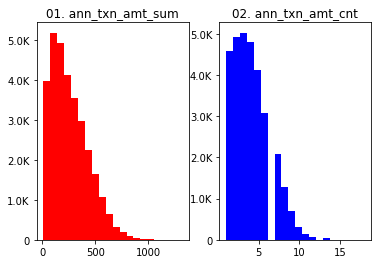

In [ ]:

!pip install pyspark_dist_explore
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2)
hist(axes[0], clnt_annual_aggregations.select('ann_txn_amt_sum'), bins = 20, color='red')
axes[0].set_title('01. ann_txn_amt_sum')

hist(axes[1], clnt_annual_aggregations.select('ann_txn_amt_cnt'), bins = 20, color='blue')
axes[1].set_title('02. ann_txn_amt_cnt')
# fig, ax = plt.subplots()
# hist(ax, clnt_annual_aggregations.select('ann_txn_amt_sum'), bins = 20, color=['red'])
# ax[0, 1].set_title('ann_txn_amt_sum')

In [ ]:
%%time



clnt_annual_aggregations_pivot = clnt_annual_aggregations.groupBy("customer_id").pivot("YEAR").agg(F.first('ann_txn_amt_sum').alias('ann_txn_amt_sum'),
                                                                          F.first('ann_txn_amt_ave').alias('ann_txn_amt_ave'),
                                                                                                  F.first('ann_txn_amt_std').alias('ann_txn_amt_std'),
                                                                                                  F.first('ann_txn_amt_var').alias('ann_txn_amt_var'),
                                                                                                  F.first('ann_txn_amt_sem').alias('ann_txn_amt_sem'),
                                                                                                  F.first('ann_txn_amt_max').alias('ann_txn_amt_max'),
                                                                                                  F.first('ann_txn_amt_min').alias('ann_txn_amt_min'),
                                                                                                  F.first('ann_txn_amt_cnt').alias('ann_txn_amt_cnt'))
clnt_annual_aggregations_pivot = clnt_annual_aggregations_pivot.na.fill(0)
clnt_annual_aggregations_pivot.show(10)


+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|customer_id|2011_ann_txn_amt_sum|2011_ann_txn_amt_ave|2011_ann_txn_amt_std|2011_ann_txn_amt_var|2011_ann_txn_amt_sem|2011_ann_txn_amt_max|2011_an

In [ ]:
%%time

print(clnt_annual_aggregations_pivot.columns)
print(clnt_annual_aggregations_pivot.printSchema())

['customer_id', '2011_ann_txn_amt_sum', '2011_ann_txn_amt_ave', '2011_ann_txn_amt_std', '2011_ann_txn_amt_var', '2011_ann_txn_amt_sem', '2011_ann_txn_amt_max', '2011_ann_txn_amt_min', '2011_ann_txn_amt_cnt', '2012_ann_txn_amt_sum', '2012_ann_txn_amt_ave', '2012_ann_txn_amt_std', '2012_ann_txn_amt_var', '2012_ann_txn_amt_sem', '2012_ann_txn_amt_max', '2012_ann_txn_amt_min', '2012_ann_txn_amt_cnt', '2013_ann_txn_amt_sum', '2013_ann_txn_amt_ave', '2013_ann_txn_amt_std', '2013_ann_txn_amt_var', '2013_ann_txn_amt_sem', '2013_ann_txn_amt_max', '2013_ann_txn_amt_min', '2013_ann_txn_amt_cnt', '2014_ann_txn_amt_sum', '2014_ann_txn_amt_ave', '2014_ann_txn_amt_std', '2014_ann_txn_amt_var', '2014_ann_txn_amt_sem', '2014_ann_txn_amt_max', '2014_ann_txn_amt_min', '2014_ann_txn_amt_cnt', '2015_ann_txn_amt_sum', '2015_ann_txn_amt_ave', '2015_ann_txn_amt_std', '2015_ann_txn_amt_var', '2015_ann_txn_amt_sem', '2015_ann_txn_amt_max', '2015_ann_txn_amt_min', '2015_ann_txn_amt_cnt']
root
 |-- customer_id: s

In [ ]:

# save
clnt_annual_aggregations_pivot.coalesce(1).write.mode("overwrite").option("header","true").csv("csv/clnt_annual_aggregations_pivot")


In [ ]:
# check if save is successful
from py4j.java_gateway import java_import
# change file name
java_import(spark._jvm, 'org.apache.hadoop.fs.Path')
fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
CSVPath = 'dbfs:/csv/clnt_annual_aggregations_pivot'
list_status = fs.listStatus(spark._jvm.org.apache.hadoop.fs.Path(CSVPath))
file_name = [file.getPath().getName() for file in list_status if file.getPath().getName().startswith('part-')][0]
print(file_name)
fs.rename(sc._jvm.Path(CSVPath+'/'+file_name), sc._jvm.Path(CSVPath+"/annual_features.csv"))
# test if save is correct and successful
test = spark.read.format("csv").option("header", "true").load(CSVPath+'/'+'annual_features.csv')
test.show(10)

part-00000-tid-8037816843308161091-27299e71-592b-43ea-aefc-44f1a58bd146-26-1-c000.csv
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|customer_id|2011_ann_txn_amt_sum|2011_ann_txn_amt_ave|2011_

In [ ]:
%%time

clnt_monthly_aggregations = txn.groupBy('customer_id','ME_DT').agg(F.sum('tran_amount').alias('mth_txn_amt_sum'), 
                                                     F.count('tran_amount').alias('mth_txn_amt_cnt'))

print('check if result matches with answer:')
clnt_monthly_aggregations.filter(clnt_monthly_aggregations.customer_id == 'CS1112').sort(clnt_monthly_aggregations.ME_DT.asc()).show()


check if result matches with answer:
+-----------+----------+---------------+---------------+
|customer_id|     ME_DT|mth_txn_amt_sum|mth_txn_amt_cnt|
+-----------+----------+---------------+---------------+
|     CS1112|2011-06-30|           56.0|              1|
|     CS1112|2011-08-31|           96.0|              1|
|     CS1112|2011-10-31|           60.0|              1|
|     CS1112|2012-04-30|           56.0|              1|
|     CS1112|2012-06-30|           52.0|              1|
|     CS1112|2012-07-31|           81.0|              1|
|     CS1112|2012-09-30|           72.0|              1|
|     CS1112|2012-12-31|           76.0|              1|
|     CS1112|2013-03-31|          105.0|              1|
|     CS1112|2013-07-31|           36.0|              1|
|     CS1112|2013-11-30|           71.0|              1|
|     CS1112|2014-04-30|           63.0|              1|
|     CS1112|2014-07-31|           90.0|              1|
|     CS1112|2014-12-31|           59.0|           

Out[20]: Text(0.5, 1.0, '02. mth_txn_amt_cnt')

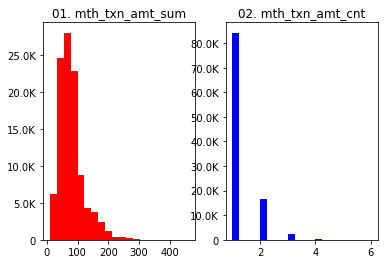

In [ ]:

fig, axes = plt.subplots(nrows=1, ncols=2)
hist(axes[0], clnt_monthly_aggregations.select('mth_txn_amt_sum'), bins = 20, color='red')
axes[0].set_title('01. mth_txn_amt_sum')

hist(axes[1], clnt_monthly_aggregations.select('mth_txn_amt_cnt'), bins = 20, color='blue')
axes[1].set_title('02. mth_txn_amt_cnt')

In [ ]:
%%time

medt = txn.select('ME_DT').distinct()
customerid = txn.select('customer_id').distinct()
print('Unique ME_DT: ', medt.count())
print('Unique customer_id:', customerid.count())

Unique ME_DT:  47
Unique customer_id: 6889
CPU times: user 10.7 ms, sys: 0 ns, total: 10.7 ms
Wall time: 2.84 s


In [ ]:
%%time
base_table_sp = medt.crossJoin(customerid)
base_table_sp = base_table_sp.withColumnRenamed('customer_id','CLNT_NO').sort('CLNT_NO','ME_DT')
print('check cross join table:')
base_table_sp.show(5)

check cross join table:
+----------+-------+
|     ME_DT|CLNT_NO|
+----------+-------+
|2011-05-31| CS1112|
|2011-06-30| CS1112|
|2011-07-31| CS1112|
|2011-08-31| CS1112|
|2011-09-30| CS1112|
+----------+-------+
only showing top 5 rows

CPU times: user 12.8 ms, sys: 0 ns, total: 12.8 ms
Wall time: 3.11 s


In [ ]:
%%time

base_table_sp_cs1112 = base_table_sp.filter(base_table_sp.CLNT_NO == 'CS1112').sort(base_table_sp.ME_DT.asc())
print('filter client CS1122:')
base_table_sp_cs1112.show()
print('number of rows in the filtered dataframe: ', base_table_sp_cs1112.count())
print('number of rows in the base table dataframe: ', base_table_sp.count())
print('distinct count of month end dates: ', base_table_sp.select('ME_DT').distinct().count())

filter client CS1122:
+----------+-------+
|     ME_DT|CLNT_NO|
+----------+-------+
|2011-05-31| CS1112|
|2011-06-30| CS1112|
|2011-07-31| CS1112|
|2011-08-31| CS1112|
|2011-09-30| CS1112|
|2011-10-31| CS1112|
|2011-11-30| CS1112|
|2011-12-31| CS1112|
|2012-01-31| CS1112|
|2012-02-29| CS1112|
|2012-03-31| CS1112|
|2012-04-30| CS1112|
|2012-05-31| CS1112|
|2012-06-30| CS1112|
|2012-07-31| CS1112|
|2012-08-31| CS1112|
|2012-09-30| CS1112|
|2012-10-31| CS1112|
|2012-11-30| CS1112|
|2012-12-31| CS1112|
+----------+-------+
only showing top 20 rows

number of rows in the filtered dataframe:  47
number of rows in the base table dataframe:  323783
distinct count of month end dates:  47
CPU times: user 16.1 ms, sys: 8.59 ms, total: 24.7 ms
Wall time: 9.83 s


In [ ]:


base_clnt_mth = base_table_sp.alias('l').join(clnt_monthly_aggregations.alias('r'), on = [base_table_sp.ME_DT == clnt_monthly_aggregations.ME_DT, 
                                                                    base_table_sp.CLNT_NO == clnt_monthly_aggregations.customer_id], how = "leftouter").select('l.ME_DT',
                                                                    'l.CLNT_NO','r.mth_txn_amt_sum','r.mth_txn_amt_cnt')
base_clnt_mth.show()
## comments to be completed

+----------+-------+---------------+---------------+
|     ME_DT|CLNT_NO|mth_txn_amt_sum|mth_txn_amt_cnt|
+----------+-------+---------------+---------------+
|2013-03-31| CS6043|           null|           null|
|2013-03-31| CS4147|           82.0|              1|
|2013-03-31| CS5539|           null|           null|
|2013-03-31| CS1217|           null|           null|
|2013-03-31| CS1171|           null|           null|
|2013-03-31| CS2724|           null|           null|
|2013-03-31| CS3802|           null|           null|
|2013-03-31| CS3780|           80.0|              1|
|2013-03-31| CS5902|           45.0|              1|
|2013-03-31| CS3494|           null|           null|
|2013-03-31| CS1850|          119.0|              2|
|2013-03-31| CS5552|           null|           null|
|2013-03-31| CS4655|           null|           null|
|2013-03-31| CS4768|           78.0|              2|
|2013-03-31| CS2892|           null|           null|
|2013-03-31| CS3904|           null|          

In [ ]:
print('number of rows: ')
base_clnt_mth.count()

number of rows: 
Out[25]: 323783

In [ ]:
# fill na with 0
base_clnt_mth = base_clnt_mth.na.fill(value=0)
base_clnt_mth.show()

+----------+-------+---------------+---------------+
|     ME_DT|CLNT_NO|mth_txn_amt_sum|mth_txn_amt_cnt|
+----------+-------+---------------+---------------+
|2013-03-31| CS6043|            0.0|              0|
|2013-03-31| CS4147|           82.0|              1|
|2013-03-31| CS5539|            0.0|              0|
|2013-03-31| CS1217|            0.0|              0|
|2013-03-31| CS1171|            0.0|              0|
|2013-03-31| CS2724|            0.0|              0|
|2013-03-31| CS3802|            0.0|              0|
|2013-03-31| CS3780|           80.0|              1|
|2013-03-31| CS5902|           45.0|              1|
|2013-03-31| CS3494|            0.0|              0|
|2013-03-31| CS1850|          119.0|              2|
|2013-03-31| CS5552|            0.0|              0|
|2013-03-31| CS4655|            0.0|              0|
|2013-03-31| CS4768|           78.0|              2|
|2013-03-31| CS2892|            0.0|              0|
|2013-03-31| CS3904|            0.0|          

In [ ]:
print('number of rows in clnt_monthly_aggregations:')
clnt_monthly_aggregations.count()

number of rows in clnt_monthly_aggregations:
Out[27]: 103234

## 1.5.1

Null values happen because the table base_table_pd has more rows than the other, therefore, when left outer joining, the some values in a particular row would be empty (the row exist in the left table but not the right table), then these empty values are given the value of null; to replace these null values, 0 is selected because the columns represent numerical values, and the null suggests that these particular rows do not have values in these columns. With respect to the difference between base_clnt_mth and clnt_monthly_aggregations, the number of rows in the former is 47x6889 = 323783, and that of the latter is only 103234. This is because the latter table contains only combinations of customer_id and ME_DT that have values in transaction amount, whereas the former contains all possible combinations of customer_id and ME_DT.

In [ ]:

base_clnt_mth = base_clnt_mth.sort(base_clnt_mth.CLNT_NO.asc(),base_clnt_mth.ME_DT.asc())
base_clnt_mth.show()

+----------+-------+---------------+---------------+
|     ME_DT|CLNT_NO|mth_txn_amt_sum|mth_txn_amt_cnt|
+----------+-------+---------------+---------------+
|2011-05-31| CS1112|            0.0|              0|
|2011-06-30| CS1112|           56.0|              1|
|2011-07-31| CS1112|            0.0|              0|
|2011-08-31| CS1112|           96.0|              1|
|2011-09-30| CS1112|            0.0|              0|
|2011-10-31| CS1112|           60.0|              1|
|2011-11-30| CS1112|            0.0|              0|
|2011-12-31| CS1112|            0.0|              0|
|2012-01-31| CS1112|            0.0|              0|
|2012-02-29| CS1112|            0.0|              0|
|2012-03-31| CS1112|            0.0|              0|
|2012-04-30| CS1112|           56.0|              1|
|2012-05-31| CS1112|            0.0|              0|
|2012-06-30| CS1112|           52.0|              1|
|2012-07-31| CS1112|           81.0|              1|
|2012-08-31| CS1112|            0.0|          

In [ ]:

from pyspark.sql import Window
rolling_w_3 = Window.partitionBy('CLNT_NO').orderBy('ME_DT').rowsBetween(-2, 0)
rolling_w_6 = Window.partitionBy('CLNT_NO').orderBy('ME_DT').rowsBetween(-5, 0)
rolling_w_12 = Window.partitionBy('CLNT_NO').orderBy('ME_DT').rowsBetween(-11, 0)
rolling_features_3M = base_clnt_mth.select('CLNT_NO','ME_DT',F.sum('mth_txn_amt_sum').over(rolling_w_3).alias('amt_sum_3M'),
                    F.mean('mth_txn_amt_sum').over(rolling_w_3).alias('amt_mean_3M'),
                    F.max('mth_txn_amt_sum').over(rolling_w_3).alias('amt_max_3M'),
                    F.sum('mth_txn_amt_cnt').over(rolling_w_3).alias('txn_cnt_sum_3M'),
                    F.mean('mth_txn_amt_cnt').over(rolling_w_3).alias('txn_cnt_mean_3M'),
                    F.max('mth_txn_amt_cnt').over(rolling_w_3).alias('txn_cnt_max_3M'))


In [ ]:
# setting the first n rows to null values
rolling_features_3M.createOrReplaceTempView('rolling_features_3M')
rolling_features_3M_rank = spark.sql('''select *, rank() over (partition by CLNT_NO order by ME_DT) as rk from rolling_features_3M''')
rolling_features_3M_rank.createOrReplaceTempView('rolling_features_3M_rank')
rolling_features_3M_null = spark.sql('''select CLNT_NO, ME_DT, null as amt_sum_3M, null as amt_mean_3M, null as amt_max_3M, null as txn_cnt_sum_3M, 
null as txn_cnt_mean_3M, null as txn_cnt_max_3M from rolling_features_3M_rank where rk in (1,2)''')
rolling_features_3M = rolling_features_3M_null.unionAll(spark.sql('''select * except(rk) from rolling_features_3M_rank where rk not in (1,2)''')).sort('CLNT_NO','ME_DT')

In [ ]:
rolling_features_6M = base_clnt_mth.select('CLNT_NO','ME_DT',F.sum('mth_txn_amt_sum').over(rolling_w_6).alias('amt_sum_6M'),
                    F.mean('mth_txn_amt_sum').over(rolling_w_6).alias('amt_mean_6M'),
                    F.max('mth_txn_amt_sum').over(rolling_w_6).alias('amt_max_6M'),
                    F.sum('mth_txn_amt_cnt').over(rolling_w_6).alias('txn_cnt_sum_6M'),
                    F.mean('mth_txn_amt_cnt').over(rolling_w_6).alias('txn_cnt_mean_6M'),
                    F.max('mth_txn_amt_cnt').over(rolling_w_6).alias('txn_cnt_max_6M'))


rolling_features_12M = base_clnt_mth.select('CLNT_NO','ME_DT',F.sum('mth_txn_amt_sum').over(rolling_w_12).alias('amt_sum_12M'),
                    F.mean('mth_txn_amt_sum').over(rolling_w_12).alias('amt_mean_12M'),
                    F.max('mth_txn_amt_sum').over(rolling_w_12).alias('amt_max_12M'),
                    F.sum('mth_txn_amt_cnt').over(rolling_w_12).alias('txn_cnt_sum_12M'),
                    F.mean('mth_txn_amt_cnt').over(rolling_w_12).alias('txn_cnt_mean_12M'),
                    F.max('mth_txn_amt_cnt').over(rolling_w_12).alias('txn_cnt_max_12M'))


In [ ]:
# setting the first n rows to null values
rolling_features_6M.createOrReplaceTempView('rolling_features_6M')
rolling_features_6M_rank = spark.sql('''select *, rank() over (partition by CLNT_NO order by ME_DT) as rk from rolling_features_6M''')
rolling_features_6M_rank.createOrReplaceTempView('rolling_features_6M_rank')
rolling_features_6M_null = spark.sql('''select CLNT_NO, ME_DT, null as amt_sum_6M, null as amt_mean_6M, null as amt_max_6M, null as txn_cnt_sum_6M, 
null as txn_cnt_mean_6M, null as txn_cnt_max_6M from rolling_features_6M_rank where rk in (1,2,3,4,5)''')
rolling_features_6M = rolling_features_6M_null.unionAll(spark.sql('''select * except(rk) from rolling_features_6M_rank where rk not in (1,2,3,4,5)''')).sort('CLNT_NO','ME_DT')


rolling_features_12M.createOrReplaceTempView('rolling_features_12M')
rolling_features_12M_rank = spark.sql('''select *, rank() over (partition by CLNT_NO order by ME_DT) as rk from rolling_features_12M''')
rolling_features_12M_rank.createOrReplaceTempView('rolling_features_12M_rank')
rolling_features_12M_null = spark.sql('''select CLNT_NO, ME_DT, null as amt_sum_12M, null as amt_mean_12M, null as amt_max_12M, null as txn_cnt_sum_12M, 
null as txn_cnt_mean_12M, null as txn_cnt_max_12M from rolling_features_12M_rank where rk in (1,2,3,4,5,6,7,8,9,10,11)''')
rolling_features_12M = rolling_features_12M_null.unionAll(spark.sql('''select * except(rk) from rolling_features_12M_rank where rk not in (1,2,3,4,5,6,7,8,9,10,11)''')).sort('CLNT_NO','ME_DT')



In [ ]:
# check with 3M table
rolling_features_3M.show()

+-------+----------+----------+------------------+----------+--------------+------------------+--------------+
|CLNT_NO|     ME_DT|amt_sum_3M|       amt_mean_3M|amt_max_3M|txn_cnt_sum_3M|   txn_cnt_mean_3M|txn_cnt_max_3M|
+-------+----------+----------+------------------+----------+--------------+------------------+--------------+
| CS1112|2011-05-31|      null|              null|      null|          null|              null|          null|
| CS1112|2011-06-30|      null|              null|      null|          null|              null|          null|
| CS1112|2011-07-31|      56.0|18.666666666666668|      56.0|             1|0.3333333333333333|             1|
| CS1112|2011-08-31|     152.0|50.666666666666664|      96.0|             2|0.6666666666666666|             1|
| CS1112|2011-09-30|      96.0|              32.0|      96.0|             1|0.3333333333333333|             1|
| CS1112|2011-10-31|     156.0|              52.0|      96.0|             2|0.6666666666666666|             1|
|

In [ ]:

base_clnt_month = base_clnt_mth.sort('CLNT_NO','ME_DT')
rolling_features_3M = rolling_features_3M.sort('CLNT_NO','ME_DT')
rolling_features_6M = rolling_features_6M.sort('CLNT_NO','ME_DT')
rolling_features_12M = rolling_features_12M.sort('CLNT_NO','ME_DT')
all_rolling_features = base_clnt_month.join(rolling_features_3M, ['CLNT_NO','ME_DT']).join(rolling_features_6M, ['CLNT_NO','ME_DT']).join(rolling_features_12M, ['CLNT_NO','ME_DT']).sort('CLNT_NO', 'ME_DT')

In [ ]:
all_rolling_features.show(100)

+-------+----------+---------------+---------------+----------+------------------+----------+--------------+------------------+--------------+----------+------------------+----------+--------------+-------------------+--------------+-----------+------------------+-----------+---------------+-------------------+---------------+
|CLNT_NO|     ME_DT|mth_txn_amt_sum|mth_txn_amt_cnt|amt_sum_3M|       amt_mean_3M|amt_max_3M|txn_cnt_sum_3M|   txn_cnt_mean_3M|txn_cnt_max_3M|amt_sum_6M|       amt_mean_6M|amt_max_6M|txn_cnt_sum_6M|    txn_cnt_mean_6M|txn_cnt_max_6M|amt_sum_12M|      amt_mean_12M|amt_max_12M|txn_cnt_sum_12M|   txn_cnt_mean_12M|txn_cnt_max_12M|
+-------+----------+---------------+---------------+----------+------------------+----------+--------------+------------------+--------------+----------+------------------+----------+--------------+-------------------+--------------+-----------+------------------+-----------+---------------+-------------------+---------------+
| CS1112|2011

In [ ]:

print('number of rows in all_rolling_features: ',all_rolling_features.count())
print('number of columns in all_rolling_features: ', len(all_rolling_features.columns))
# save
all_rolling_features.coalesce(1).write.mode("overwrite").option("header","true").csv("csv/mth_rolling_features")


# change file name
java_import(spark._jvm, 'org.apache.hadoop.fs.Path')
fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
CSVPath = 'dbfs:/csv/mth_rolling_features'
list_status = fs.listStatus(spark._jvm.org.apache.hadoop.fs.Path(CSVPath))
file_name = [file.getPath().getName() for file in list_status if file.getPath().getName().startswith('part-')][0]
print(file_name)
fs.rename(sc._jvm.Path(CSVPath+'/'+file_name), sc._jvm.Path(CSVPath+"/mth_rolling_features.csv"))
# test if save is correct and successful
test = spark.read.format("csv").option("header", "true").load(CSVPath+'/'+'mth_rolling_features.csv')
test.show(10)

number of rows in all_rolling_features:  323783
number of columns in all_rolling_features:  22
part-00000-tid-8276794977990124350-2a37d08f-fcc7-448c-a759-b2ef82d21f7b-255-1-c000.csv
+-------+----------+---------------+---------------+----------+------------------+----------+--------------+------------------+--------------+----------+------------------+----------+--------------+-------------------+--------------+-----------+------------+-----------+---------------+----------------+---------------+
|CLNT_NO|     ME_DT|mth_txn_amt_sum|mth_txn_amt_cnt|amt_sum_3M|       amt_mean_3M|amt_max_3M|txn_cnt_sum_3M|   txn_cnt_mean_3M|txn_cnt_max_3M|amt_sum_6M|       amt_mean_6M|amt_max_6M|txn_cnt_sum_6M|    txn_cnt_mean_6M|txn_cnt_max_6M|amt_sum_12M|amt_mean_12M|amt_max_12M|txn_cnt_sum_12M|txn_cnt_mean_12M|txn_cnt_max_12M|
+-------+----------+---------------+---------------+----------+------------------+----------+--------------+------------------+--------------+----------+------------------+------

In [ ]:

txn1 = txn.withColumn('day_of_the_week', (F.dayofweek('txn_date')+5)%7).withColumn('day_name',F.date_format('txn_date', 'EEEE'))
txn1.show()

+-----------+-----------+----------+----------+----+---------------+---------+
|customer_id|tran_amount|  txn_date|     ME_DT|YEAR|day_of_the_week| day_name|
+-----------+-----------+----------+----------+----+---------------+---------+
|     CS5295|         35|2013-02-11|2013-02-28|2013|              0|   Monday|
|     CS4768|         39|2015-03-15|2015-03-31|2015|              6|   Sunday|
|     CS2122|         52|2013-02-26|2013-02-28|2013|              1|  Tuesday|
|     CS1217|         99|2011-11-16|2011-11-30|2011|              2|Wednesday|
|     CS1850|         78|2013-11-20|2013-11-30|2013|              2|Wednesday|
|     CS5539|         81|2014-03-26|2014-03-31|2014|              2|Wednesday|
|     CS2724|         93|2012-02-06|2012-02-29|2012|              0|   Monday|
|     CS5902|         89|2015-01-30|2015-01-31|2015|              4|   Friday|
|     CS6040|         76|2013-01-08|2013-01-31|2013|              1|  Tuesday|
|     CS3802|         75|2013-08-20|2013-08-31|2013|

Out[38]: Text(0.5, 1.0, '01. day_txn_cnt')

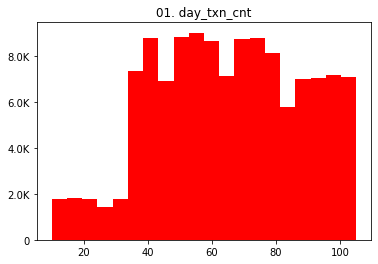

In [ ]:


fig, axes = plt.subplots(nrows=1, ncols=1)
hist(axes, txn1.select(F.col("tran_amount").cast("double")), bins = 20, color='red')
axes.set_title('01. day_txn_cnt')



In [ ]:



txn1_pivot = txn1.withColumn('piv', F.concat(txn1.YEAR,F.lit('_'), txn1.day_name))
txn1_pivot = txn1_pivot.groupBy("customer_id").pivot("piv").agg(F.count('tran_amount'))
# txn1_pivot.show()
txn1_pivot = txn1_pivot.na.fill(0).sort('customer_id')
txn1_pivot.show()

+-----------+-----------+-----------+-------------+-----------+-------------+------------+--------------+-----------+-----------+-------------+-----------+-------------+------------+--------------+-----------+-----------+-------------+-----------+-------------+------------+--------------+-----------+-----------+-------------+-----------+-------------+------------+--------------+-----------+-----------+-------------+-----------+-------------+------------+--------------+
|customer_id|2011_Friday|2011_Monday|2011_Saturday|2011_Sunday|2011_Thursday|2011_Tuesday|2011_Wednesday|2012_Friday|2012_Monday|2012_Saturday|2012_Sunday|2012_Thursday|2012_Tuesday|2012_Wednesday|2013_Friday|2013_Monday|2013_Saturday|2013_Sunday|2013_Thursday|2013_Tuesday|2013_Wednesday|2014_Friday|2014_Monday|2014_Saturday|2014_Sunday|2014_Thursday|2014_Tuesday|2014_Wednesday|2015_Friday|2015_Monday|2015_Saturday|2015_Sunday|2015_Thursday|2015_Tuesday|2015_Wednesday|
+-----------+-----------+-----------+-------------+-

In [ ]:

print('row count: ',txn1_pivot.count(), 'same as output in section 1.2')
print('column count: ', len(txn1_pivot.columns))

row count:  6889 same as output in section 1.2
column count:  36


In [ ]:
txn1_pivot.coalesce(1).write.mode("overwrite").option("header","true").option("delimiter", "~").csv("csv/annual_day_of_week_counts_pivot")

In [ ]:
from py4j.java_gateway import java_import
java_import(spark._jvm, 'org.apache.hadoop.fs.Path')
fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
CSVPath = 'dbfs:/csv/annual_day_of_week_counts_pivot'
list_status = fs.listStatus(spark._jvm.org.apache.hadoop.fs.Path(CSVPath))
file_name = [file.getPath().getName() for file in list_status if file.getPath().getName().startswith('part-')][0]
print(file_name)
fs.rename(sc._jvm.Path(CSVPath+'/'+file_name), sc._jvm.Path(CSVPath+"/annual_day_of_week_counts_pivot.csv"))

part-00000-tid-4863005760051926054-5407df78-4fc0-40a9-9fc4-3fc0b5357247-275-1-c000.csv
Out[42]: True

In [ ]:

txn2 = txn1.groupby('customer_id','ME_DT').pivot('day_name').agg(F.count('day_name').alias('cnt')).sort("customer_id",'ME_DT').na.fill(0)
txn2.show()

+-----------+----------+------+------+--------+------+--------+-------+---------+
|customer_id|     ME_DT|Friday|Monday|Saturday|Sunday|Thursday|Tuesday|Wednesday|
+-----------+----------+------+------+--------+------+--------+-------+---------+
|     CS1112|2011-06-30|     0|     0|       0|     0|       0|      0|        1|
|     CS1112|2011-08-31|     1|     0|       0|     0|       0|      0|        0|
|     CS1112|2011-10-31|     0|     0|       0|     1|       0|      0|        0|
|     CS1112|2012-04-30|     0|     0|       0|     1|       0|      0|        0|
|     CS1112|2012-06-30|     0|     0|       0|     1|       0|      0|        0|
|     CS1112|2012-07-31|     0|     0|       0|     0|       0|      1|        0|
|     CS1112|2012-09-30|     0|     0|       0|     1|       0|      0|        0|
|     CS1112|2012-12-31|     0|     0|       1|     0|       0|      0|        0|
|     CS1112|2013-03-31|     1|     0|       0|     0|       0|      0|        0|
|     CS1112|201

In [ ]:

mth_day_counts = base_table_sp.alias('l').join(txn2.alias('r'), on = [base_table_sp.ME_DT == txn2.ME_DT, 
                                                base_table_sp.CLNT_NO == txn2.customer_id], how = 'leftouter').select('l.CLNT_NO', 'l.ME_DT',
                                                                                                                                          'r.Friday','r.Monday',
                                                                                                                                          'r.Saturday','r.Sunday',
                                                                                                                                          'r.Thursday','r.Tuesday',
                                                                                                                                          'r.Wednesday')
mth_day_counts = mth_day_counts.na.fill(0)

mth_day_counts.coalesce(1).write.mode("overwrite").option("header","true").option("delimiter", "~").csv("csv/mth_day_counts")
from py4j.java_gateway import java_import
java_import(spark._jvm, 'org.apache.hadoop.fs.Path')
fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
CSVPath = 'dbfs:/csv/mth_day_counts'
list_status = fs.listStatus(spark._jvm.org.apache.hadoop.fs.Path(CSVPath))
file_name = [file.getPath().getName() for file in list_status if file.getPath().getName().startswith('part-')][0]
print(file_name)
fs.rename(sc._jvm.Path(CSVPath+'/'+file_name), sc._jvm.Path(CSVPath+"/mth_day_counts.csv"))


part-00000-tid-8673760059991963901-02b20ac9-b441-49fc-bdd1-ffbcf1f20d47-291-1-c000.csv
Out[44]: True

In [ ]:

last_monthly_purchase = txn.groupby('customer_id','ME_DT').agg(F.max('txn_date').alias('last_monthly_purchase')).withColumnRenamed('customer_id', 'CLNT_NO')
last_monthly_purchase = last_monthly_purchase.sort('customer_id', 'ME_DT')
last_monthly_purchase.show()

+-------+----------+---------------------+
|CLNT_NO|     ME_DT|last_monthly_purchase|
+-------+----------+---------------------+
| CS1112|2011-06-30|           2011-06-15|
| CS1112|2011-08-31|           2011-08-19|
| CS1112|2011-10-31|           2011-10-02|
| CS1112|2012-04-30|           2012-04-08|
| CS1112|2012-06-30|           2012-06-24|
| CS1112|2012-07-31|           2012-07-03|
| CS1112|2012-09-30|           2012-09-16|
| CS1112|2012-12-31|           2012-12-15|
| CS1112|2013-03-31|           2013-03-01|
| CS1112|2013-07-31|           2013-07-01|
| CS1112|2013-11-30|           2013-11-13|
| CS1112|2014-04-30|           2014-04-29|
| CS1112|2014-07-31|           2014-07-16|
| CS1112|2014-12-31|           2014-12-04|
| CS1112|2015-01-31|           2015-01-14|
| CS1113|2011-05-31|           2011-05-27|
| CS1113|2011-07-31|           2011-07-25|
| CS1113|2011-10-31|           2011-10-23|
| CS1113|2012-03-31|           2012-03-30|
| CS1113|2012-09-30|           2012-09-05|
+-------+--

In [ ]:


last_monthly_purchase_base = base_table_sp.alias('l').join(last_monthly_purchase.alias('r'), 
                                                           on = [base_table_sp.ME_DT == last_monthly_purchase.ME_DT, 
                                                                base_table_sp.CLNT_NO == last_monthly_purchase.CLNT_NO], how = 'leftouter').\
select('l.CLNT_NO','l.ME_DT','r.last_monthly_purchase')
last_monthly_purchase_base = last_monthly_purchase_base.sort('CLNT_NO','ME_DT')
last_monthly_purchase_base.show()

+-------+----------+---------------------+
|CLNT_NO|     ME_DT|last_monthly_purchase|
+-------+----------+---------------------+
| CS1112|2011-05-31|                 null|
| CS1112|2011-06-30|           2011-06-15|
| CS1112|2011-07-31|                 null|
| CS1112|2011-08-31|           2011-08-19|
| CS1112|2011-09-30|                 null|
| CS1112|2011-10-31|           2011-10-02|
| CS1112|2011-11-30|                 null|
| CS1112|2011-12-31|                 null|
| CS1112|2012-01-31|                 null|
| CS1112|2012-02-29|                 null|
| CS1112|2012-03-31|                 null|
| CS1112|2012-04-30|           2012-04-08|
| CS1112|2012-05-31|                 null|
| CS1112|2012-06-30|           2012-06-24|
| CS1112|2012-07-31|           2012-07-03|
| CS1112|2012-08-31|                 null|
| CS1112|2012-09-30|           2012-09-16|
| CS1112|2012-10-31|                 null|
| CS1112|2012-11-30|                 null|
| CS1112|2012-12-31|           2012-12-15|
+-------+--

In [ ]:


window = Window.partitionBy('CLNT_NO').orderBy('ME_DT').rowsBetween(Window.unboundedPreceding, Window.currentRow)
          
filled_column = F.last('last_monthly_purchase', ignorenulls=True).over(window)

last_monthly_purchase_base = last_monthly_purchase_base.withColumn('last_monthly_purchase', filled_column)

last_monthly_purchase_base.show(10)     

+-------+----------+---------------------+
|CLNT_NO|     ME_DT|last_monthly_purchase|
+-------+----------+---------------------+
| CS1112|2011-05-31|                 null|
| CS1112|2011-06-30|           2011-06-15|
| CS1112|2011-07-31|           2011-06-15|
| CS1112|2011-08-31|           2011-08-19|
| CS1112|2011-09-30|           2011-08-19|
| CS1112|2011-10-31|           2011-10-02|
| CS1112|2011-11-30|           2011-10-02|
| CS1112|2011-12-31|           2011-10-02|
| CS1112|2012-01-31|           2011-10-02|
| CS1112|2012-02-29|           2011-10-02|
+-------+----------+---------------------+
only showing top 10 rows



In [ ]:


last_monthly_purchase_base1 = last_monthly_purchase_base.withColumn('days_since_last_txn', F.datediff('ME_DT', 'last_monthly_purchase')) 
last_monthly_purchase_base1.show()

+-------+----------+---------------------+-------------------+
|CLNT_NO|     ME_DT|last_monthly_purchase|days_since_last_txn|
+-------+----------+---------------------+-------------------+
| CS1112|2011-05-31|                 null|               null|
| CS1112|2011-06-30|           2011-06-15|                 15|
| CS1112|2011-07-31|           2011-06-15|                 46|
| CS1112|2011-08-31|           2011-08-19|                 12|
| CS1112|2011-09-30|           2011-08-19|                 42|
| CS1112|2011-10-31|           2011-10-02|                 29|
| CS1112|2011-11-30|           2011-10-02|                 59|
| CS1112|2011-12-31|           2011-10-02|                 90|
| CS1112|2012-01-31|           2011-10-02|                121|
| CS1112|2012-02-29|           2011-10-02|                150|
| CS1112|2012-03-31|           2011-10-02|                181|
| CS1112|2012-04-30|           2012-04-08|                 22|
| CS1112|2012-05-31|           2012-04-08|             

Out[49]: Text(0.5, 1.0, '01. days_since_last_txn')

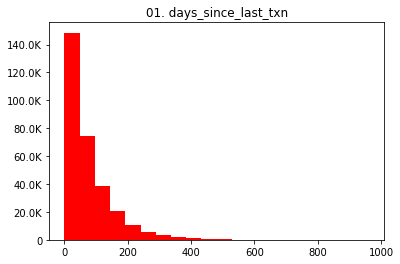

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1)
hist(axes, last_monthly_purchase_base1.select('days_since_last_txn'), bins = 20, color='red')
axes.set_title('01. days_since_last_txn')

In [ ]:
last_monthly_purchase_base1 = last_monthly_purchase_base1.na.fill(0)